In [1]:
!pip install pandasql
!pip install tensorflow
!pip install keras

In [3]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandasql as ps

1. Extract the reviews and ratings from the merged data file and make an array list of all the reviews
2. Map the values of rating into postive and negative with threshold >7

In [4]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('Merged_Dataset.csv')
df = df[['Review', 'Rating', 'Drug']]
review = list(df.Review)
labels = np.where(df['Rating']>7, 1, 0)
#review[8008]
review[8107]

'"Extreme stomach discomfort and nausea as well as severe headaches and vaginal itch"'

Checking the review and ratings for few 

In [5]:
for i in range (8102,8115):
    print("Review: ", review[i])
    print("Label 1 for Postive and 0 for negative: ", labels[i])
    print('\n')

Review:  "I&#039;m currently on day two of the pill, and I already feel much better.

The only downside is how awake and energized it makes me! I took the second pill on day 1 too late and now I&#039;m wide awake when I should be sleepy. Oops! At least I feel better :)"
Label 1 for Postive and 0 for negative:  1


Review:  "This medicine gave me diarrhea."
Label 1 for Postive and 0 for negative:  0


Review:  "Helped loosen this putty gunk in my lungs making my coughing more effective and less effort  required."
Label 1 for Postive and 0 for negative:  0


Review:  "I started taking Ceftin for Bronchitis and I felt better within 2 days. I stayed on it for 6 weeks and my sinus condition and ETD symptoms went away after 4 years. This was a miracle for me."
Label 1 for Postive and 0 for negative:  1


Review:  "Disclosure: This is just one person&#039;s experience. As such It does not have any scientific validity. However, I hope some scientists will consider some actual research on this.

Defining a function for getting CV and tfID vectors for review analysis

In [6]:
def _tfIDV(list_review):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(list_review)
    X = X.toarray()
    return X

Using the defined function get the tfID vectors and categorical label encoding

In [7]:
data = _tfIDV(review)
labels = to_categorical(labels, num_classes=2)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, shuffle=False)

In [8]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Creating a Simple Neural Network using keras API

In [9]:
def _createModel():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25, input_shape=(x_train.shape[1],)))
    model.add(layers.BatchNormalization(momentum=0.8))    
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(25))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(25))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(2, activation='softmax'))   
    model.summary()
    return model 

Compiling the model with binary_crossentropy loss function and optimizing with adam optimizer

In [10]:
model = _createModel()
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])
hist = model.fit(
    x_train, y_train,
    epochs= 10,
    batch_size = 100,
    validation_data = (x_test, y_test))
print("Avg. Val_Accuracy from sklearn_CV:", np.mean(hist.history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                292900    
_________________________________________________________________
batch_normalization (BatchNo (None, 25)                100       
_________________________________________________________________
activation (Activation)      (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0

Visualizing training loss and accuracy

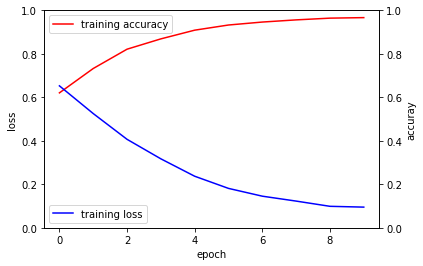

In [12]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['accuracy'], 'r', label='training accuracy')
acc_ax.plot(hist.history['loss'], 'b', label='training loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Evaluating model performance with scoring metrics

In [13]:
scores = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Evaluation metrics for Sentiment Analysis: ", '\n', "Loss: ", scores[0], '\n'
     , "Accuracy: ", scores[1], '\n', "F1_Score: ", score[2], '\n', "Precision: ", score[0], '\n', 
     "Recall: ", score[1])

Evaluation metrics for Sentiment Analysis:  
 Loss:  0.94026780128479 
 Accuracy:  0.6790123581886292 
 F1_Score:  0.678597779927528 
 Precision:  0.6786000483836826 
 Recall:  0.6790910698943751


In [14]:
def _posneg(x):
    if x == 0:
        return 'negative'
    if x == 1:
        return 'positive'

Viewing some of the reviews with actual and predicted values

In [17]:
def _posneg1(x):
    if x == 0:
        return 'negative'
    if x == 1:
        return 'positive'

In [18]:
preds = model.predict(data)
preds = np.argmax(preds, axis=1)
d = {'Review':review[:], 
    'predicted_label': preds[:]}
table = pd.DataFrame(data=d)
tableP = table['predicted_label'].apply(_posneg1)
table = table['Review']
res = pd.concat([table, tableP], axis=1, sort=False)
print('\n')
print(res)
print('\n')



                                                 Review predicted_label
0     "This drug saved my life, I had been on almost...        positive
1     "Geodon is a very effective drug for me.  Comp...        positive
2     "This medicine completely changed my life in t...        positive
3     "I&#039;ve been on geodon for about three week...        negative
4     "I switched from Risperidal to Abilify two yea...        positive
...                                                 ...             ...
8901  "I was very pleased with Integra F to treat my...        positive
8902  "I have pots syndrome And low blood plasma..\r...        negative
8903  "Was taking twice a day while I was pregnant. ...        negative
8904  "I had a haematocrit of 18 and I started takin...        positive
8905  "Went from 8.5 hemoglobin to 11 and then back ...        negative

[8906 rows x 2 columns]




In [19]:
pred_labels = pd.DataFrame(res)

In [20]:
pred_labels.to_csv("predicted_lables.csv")

In [21]:
df2 = pd.read_csv('predicted_lables.csv')

In [22]:
df2.iloc[8101:8112]

,Unnamed: 0,Review,predicted_label
8101,8101,"""This antibiotic worked wonders for my cough/b...",positive
8102,8102,"""I&#039;m currently on day two of the pill, an...",negative
8103,8103,"""This medicine gave me diarrhea.""",negative
8104,8104,"""Helped loosen this putty gunk in my lungs mak...",positive
8105,8105,"""I started taking Ceftin for Bronchitis and I ...",positive
8106,8106,"""Disclosure: This is just one person&#039;s ex...",positive
8107,8107,"""Extreme stomach discomfort and nausea as well...",negative
8108,8108,"""On March 23, 2017 went to urgent care and was...",negative
8109,8109,"""Dosage was 500 mg for 10 days. Stopped after ...",negative
8110,8110,"""I took Mucinex for a bad case of bronchitis. ...",negative


In [23]:
df2.iloc[8000:8010]

,Unnamed: 0,Review,predicted_label
8000,8000,"""This drug is a lifesaver for my wife, but tak...",negative
8001,8001,"""Ok first off whoever said to take with milk i...",negative
8002,8002,"""Very powerful. Works good for the infections ...",positive
8003,8003,"""Took this last year for my first bout with pn...",positive
8004,8004,"""It cleared me right up, stopped coughing like...",positive
8005,8005,"""Was prescribed doxycycline hcl for bronchitis...",positive
8006,8006,"""I have asthma and recently came\r\ndown with ...",positive
8007,8007,"""On my third day with Levaquin. Only problem t...",positive
8008,8008,"""I cannot sleep. """,negative
8009,8009,"""I&#039;ve been on Qvar 40mg 2 shots twice a d...",positive


In [24]:
df2 = df2.drop("Unnamed: 0", axis = 1)

In [25]:
df2

,Review,predicted_label
0,"""This drug saved my life, I had been on almost...",positive
1,"""Geodon is a very effective drug for me. Comp...",positive
2,"""This medicine completely changed my life in t...",positive
3,"""I&#039;ve been on geodon for about three week...",negative
4,"""I switched from Risperidal to Abilify two yea...",positive
...,...,...
8901,"""I was very pleased with Integra F to treat my...",positive
8902,"""I have pots syndrome And low blood plasma..\r...",negative
8903,"""Was taking twice a day while I was pregnant. ...",negative
8904,"""I had a haematocrit of 18 and I started takin...",positive


In [26]:
df1 = pd.read_csv("Merged_Dataset.csv")

In [27]:
df1

,Drug,Disease,Review,Rating,UsefulCount,Symptoms
0,Olanzapine,schizophrenia,"""This drug saved my life, I had been on almost...",10,6,"['hallucinations auditory', 'hypersomnolence',..."
1,Ziprasidone,schizophrenia,"""Geodon is a very effective drug for me. Comp...",10,33,"['hallucinations auditory', 'hypersomnolence',..."
2,Loxapine,schizophrenia,"""This medicine completely changed my life in t...",10,22,"['hallucinations auditory', 'hypersomnolence',..."
3,Ziprasidone,schizophrenia,"""I&#039;ve been on geodon for about three week...",7,6,"['hallucinations auditory', 'hypersomnolence',..."
4,Abilify,schizophrenia,"""I switched from Risperidal to Abilify two yea...",10,53,"['hallucinations auditory', 'hypersomnolence',..."
...,...,...,...,...,...,...
8901,Integra F,anemia,"""I was very pleased with Integra F to treat my...",9,29,"['chill', 'guaiac positive', 'monoclonal', 'ec..."
8902,Procrit,anemia,"""I have pots syndrome And low blood plasma..\r...",1,0,"['chill', 'guaiac positive', 'monoclonal', 'ec..."
8903,Multivitamin with iron,anemia,"""Was taking twice a day while I was pregnant. ...",8,5,"['chill', 'guaiac positive', 'monoclonal', 'ec..."
8904,Multivitamin with iron,anemia,"""I had a haematocrit of 18 and I started takin...",10,22,"['chill', 'guaiac positive', 'monoclonal', 'ec..."


In [28]:
df1.dtypes

Drug           object
Disease        object
Review         object
Rating          int64
UsefulCount     int64
Symptoms       object
dtype: object

In [31]:
ps.sqldf("""select Review, predicted_label, count(*) as cnt from df2 group by predicted_label, review having cnt>2""")

,Review,predicted_label,cnt
0,"""Good""",negative,3
1,"""I have had grand mal seizures since I was 9 y...",positive,4


In [32]:
ps.sqldf("""select * from df2 where review like '%"Good"%'""")

,Review,predicted_label
0,"""Good""",negative
1,"""Good""",negative
2,"""Good""",negative


In [33]:
df3 = ps.sqldf("""select distinct review,predicted_label from df2""")

In [34]:
merged_data = ps.sqldf("""select df1.*,df3.predicted_label from df1 left join df3 on df1.Review=df3.Review""")

In [35]:
merged_data

,Drug,Disease,Review,Rating,UsefulCount,Symptoms,predicted_label
0,Olanzapine,schizophrenia,"""This drug saved my life, I had been on almost...",10,6,"['hallucinations auditory', 'hypersomnolence',...",positive
1,Ziprasidone,schizophrenia,"""Geodon is a very effective drug for me. Comp...",10,33,"['hallucinations auditory', 'hypersomnolence',...",positive
2,Loxapine,schizophrenia,"""This medicine completely changed my life in t...",10,22,"['hallucinations auditory', 'hypersomnolence',...",positive
3,Ziprasidone,schizophrenia,"""I&#039;ve been on geodon for about three week...",7,6,"['hallucinations auditory', 'hypersomnolence',...",negative
4,Abilify,schizophrenia,"""I switched from Risperidal to Abilify two yea...",10,53,"['hallucinations auditory', 'hypersomnolence',...",positive
...,...,...,...,...,...,...,...
8901,Integra F,anemia,"""I was very pleased with Integra F to treat my...",9,29,"['chill', 'guaiac positive', 'monoclonal', 'ec...",positive
8902,Procrit,anemia,"""I have pots syndrome And low blood plasma..\r...",1,0,"['chill', 'guaiac positive', 'monoclonal', 'ec...",negative
8903,Multivitamin with iron,anemia,"""Was taking twice a day while I was pregnant. ...",8,5,"['chill', 'guaiac positive', 'monoclonal', 'ec...",negative
8904,Multivitamin with iron,anemia,"""I had a haematocrit of 18 and I started takin...",10,22,"['chill', 'guaiac positive', 'monoclonal', 'ec...",positive


In [36]:
merged_data = merged_data.rename({'predicted_label':'sentiment_review'}, axis =1)

In [37]:
merged_data.drop(['Rating', 'Symptoms'], axis =1)

,Drug,Disease,Review,UsefulCount,sentiment_review
0,Olanzapine,schizophrenia,"""This drug saved my life, I had been on almost...",6,positive
1,Ziprasidone,schizophrenia,"""Geodon is a very effective drug for me. Comp...",33,positive
2,Loxapine,schizophrenia,"""This medicine completely changed my life in t...",22,positive
3,Ziprasidone,schizophrenia,"""I&#039;ve been on geodon for about three week...",6,negative
4,Abilify,schizophrenia,"""I switched from Risperidal to Abilify two yea...",53,positive
...,...,...,...,...,...
8901,Integra F,anemia,"""I was very pleased with Integra F to treat my...",29,positive
8902,Procrit,anemia,"""I have pots syndrome And low blood plasma..\r...",0,negative
8903,Multivitamin with iron,anemia,"""Was taking twice a day while I was pregnant. ...",5,negative
8904,Multivitamin with iron,anemia,"""I had a haematocrit of 18 and I started takin...",22,positive


In [38]:
merged_data.to_csv("sentiment_review.csv")